In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import datetime
import plotly
from skimage import io, transform
from skimage import io, transform
import matplotlib.pyplot as plt
from PIL import Image
from sklearn import metrics
import random
from torch.utils.data import Dataset, DataLoader
import os
import torch.optim as optim
%matplotlib inline
import torch.nn as nn

import torch.nn.functional as F

### Intro
In this project, we are examining metastatic cancers that may be present in small patches of images of tumors taken from the PCAM dataset. In this project, I will use two CNN models - a basic model as presented by PyTorch, and then ResNet, specifically ResNet 18. The idea being that we will be able to compare prediction results between the two models, and see whether one is better than the other. The training models will be built using PyTorch, with some other modules imported as needed

### EDA - Inspection / Data Visualization


In order to actually analyze the data and train the model, we will need to actually import the data from the relevant training files. We have a test set, and a training set, and we need to train the models with the training data set. In order to actually effectively use the data however, we will need to organize it into a PyTorch dataset. We will actually need to do this twice, but we will focus on creating the custom dataset for the training set. We define the training set as "CancerDiagnosisDataset", and we need to give it the generic pytorch dataset class "Dataset" - we set some initializaton parameters, such as giving it a dataframe, telling it where the data lives, and then specifying a transformation that can be applied if a transformation is specified when called. The transformation allows us to manipulate the images in order to be able to better analyze them - in the basic model this is important, but is particularly important when using ResNet models, which will be explained later. We then set three functions - one to get the number of data points, getting the name of a file associated with an image, and then retrieving that item for display/use. 

In [2]:
os.getcwd()
trainPath = 'histopathologic-cancer-detection/train'
testPath = 'histopathologic-cancer-detection/test'
trainingLabels = 'histopathologic-cancer-detection/train_labels.csv'
df = pd.read_csv(trainingLabels)

trainFileNames = []
for entry in os.listdir(trainPath):
    fullPath = os.path.join(trainPath, entry)
    if os.path.isfile(fullPath):
        trainFileNames.append(entry)



In [3]:
class CancerDiagnosisDataset(Dataset):
    def __init__(self, csv, rootDir, transform=None):
        self.df = pd.read_csv(csv)
        self.rootDir = rootDir
        self.transform = transform
        self.transformed_image = None
        
    def __len__(self):
        return len(self.df)

    def name(self, idx):
        imageName = os.path.join(self.rootDir, self.df.iloc[idx,0]).replace("\\", "/")
        imageName = imageName + ".tif"
        return imageName
        
    def __getitem__(self, idx):
        imageName = os.path.join(self.rootDir, self.df.iloc[idx,0]).replace("\\", "/")
        imageName = imageName + ".tif"
        image = io.imread(imageName)
        name = self.df.iloc[idx,0]
        label = self.df.iloc[idx, 1]
        sample = {"ID": name, "Label": label}
        
        if self.transform:
            image = self.transform(image)
            self.transformed_image = image
        return sample, image


test = CancerDiagnosisDataset(trainingLabels, trainPath)



### Visualization
Lets look at some example images from the dataset. We will sample them randomly from the imported training set, and we will display them according to classification label. The images are 96x96, which will be our X and Y axes. Note - we have to actually read the item and then use matplotlib to show the image. We will be able to see some large singular spots where there may be a tumor, and a lack of them when a tumor is not present

In [4]:
def plot(data):
    fig, axes = plt.subplots(2,4, figsize=(12,8))

    for a in axes:
        for x in range(0, 4):
            length = data.__len__()
            new_random = random.randint(1, length)
            sample, image = data.__getitem__(new_random)
            location = sample['ID'] + ".tif"
            title = "Classification Label: " + str(sample['Label'])

            #display_image = image.permute(1,2,0).numpy()

            a[x].title.set_text(title)
            #a[x].imshow(display_image)
            a[x].imshow(io.imread(os.path.join(test.rootDir, location)))

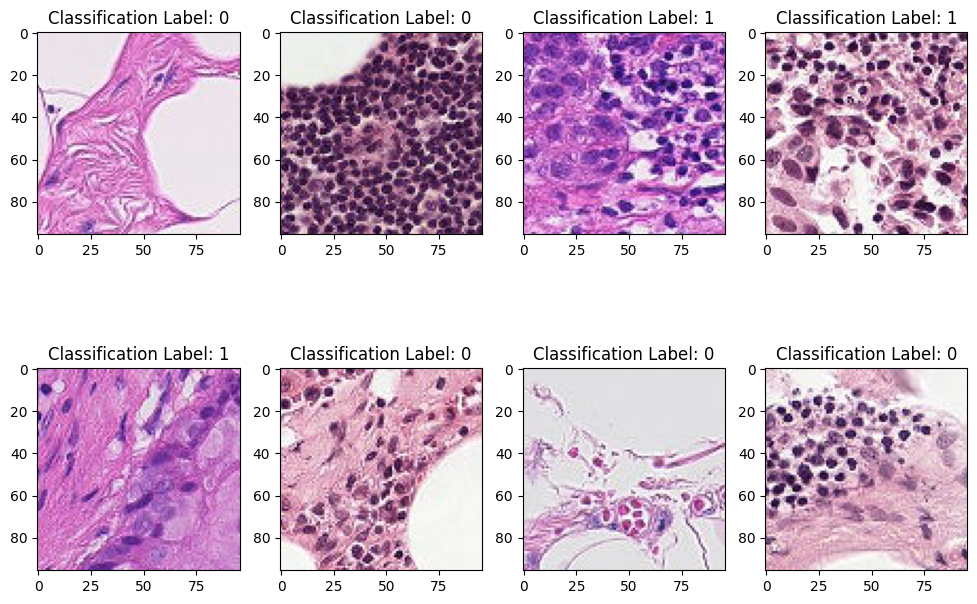

In [5]:
plot(test)

### Visualizing after Transforming

Lets apply some transformations to the images. We will convert the images to a tensor (allowing for analysis), and then resize the image to 224x224 pixels - the reason that number is chosen will be explained later. We then redefine the plotting function so that we can actually plot the images, where we can display it directly as tensor data by doing some rearranging of the columns - numpy expects it HxWxC, but the tensor displayes naturally in CxHxW - that is, the number of channels, height, and width. We note that the X-Y axes properly reflect the resizing

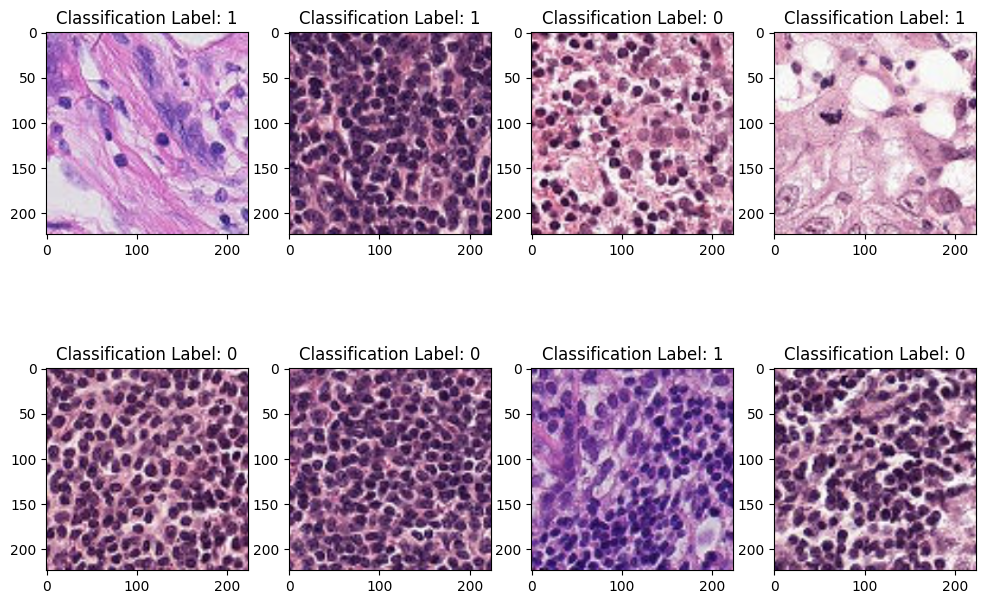

In [6]:
def newPlot(data):
    fig, axes = plt.subplots(2,4, figsize=(12,8))

    for a in axes:
        for x in range(0, 4):
            length = data.__len__()
            new_random = random.randint(1, length)
            sample, image = data.__getitem__(new_random)
            location = sample['ID'] + ".tif"
            title = "Classification Label: " + str(sample['Label'])

            display_image = image.permute(1,2,0).numpy()

            a[x].title.set_text(title)
            a[x].imshow(display_image)


newTransform = transforms.Compose([transforms.ToTensor(), transforms.Resize((224, 224))])
newTest = CancerDiagnosisDataset(trainingLabels, trainPath, newTransform)
newPlot(newTest)


### Building a CNN Classifyer
Here we begin building our classifyer. We define our convolution layers, and then our pool layer. We then define our full connected channels so that we are able to 'narrow down' the resulting layers that come from running an activation function (RELU) on our tensors in the convolution layer. We then initalize the CNN network, define a criterion (Cross Entropy Loss, as opposed to MSE since we are doing classification), and then specify that we want our optimizer to be SGD - I could have done any optimizer, but I chose SGD to build on knowledge from previous work. We then load our trained data set via a torch dataloader for easy access, and send the CNN model to my GPU, and we display the information about the input features and output features below.

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(44944, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
trainLoader = torch.utils.data.DataLoader(newTest, shuffle=True, batch_size=4, num_workers=0)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=44944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

### Running the basic CNN model

Here we actually train the model. We run it for 2 epochs (due to time), and iterate through our data from the loaded dataset. We zero out our gradient on the optimizer to allow it the possibility of finding a better gradient, and then run our inputs through the CNN model (outputs = net(inputs)) - we then calculate the loss, allow it to propagate backwards, and then step the optimizer forward. We take stock of the loss, and display it every once in a while to show the current calculated loss. We can see that the loss starts high, and then starts decreasing as the model begins to actually learn - this is a good sign. It converges to 0.440 - 0.460ish in the second epoch - potentially if we increased the number of epochs, this model would learn more, but due to time we shall leave this for now. We then save the model for future reference

In [34]:
for epoch in range(0,2):
    runningLoss = 0.0
    for i, data in enumerate(trainLoader, 0):
        info, inputs = data
        optimizer.zero_grad()
        outputs = net(inputs.to(device))
        labels = info['Label']
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        runningLoss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {runningLoss / 2000:.3f}')
            runningLoss = 0.0

            


[1,  2000] loss: 0.731
[1,  4000] loss: 0.685
[1,  6000] loss: 0.680
[1,  8000] loss: 0.672
[1, 10000] loss: 0.652
[1, 12000] loss: 0.651
[1, 14000] loss: 0.640
[1, 16000] loss: 0.634
[1, 18000] loss: 0.633
[1, 20000] loss: 0.631
[1, 22000] loss: 0.607
[1, 24000] loss: 0.582
[1, 26000] loss: 0.560
[1, 28000] loss: 0.561
[1, 30000] loss: 0.557
[1, 32000] loss: 0.538
[1, 34000] loss: 0.529
[1, 36000] loss: 0.520
[1, 38000] loss: 0.507
[1, 40000] loss: 0.504
[1, 42000] loss: 0.503
[1, 44000] loss: 0.496
[1, 46000] loss: 0.498
[1, 48000] loss: 0.497
[1, 50000] loss: 0.482
[1, 52000] loss: 0.494
[1, 54000] loss: 0.492
[2,  2000] loss: 0.466
[2,  4000] loss: 0.472
[2,  6000] loss: 0.467
[2,  8000] loss: 0.471
[2, 10000] loss: 0.472
[2, 12000] loss: 0.467
[2, 14000] loss: 0.459
[2, 16000] loss: 0.478
[2, 18000] loss: 0.468
[2, 20000] loss: 0.465
[2, 22000] loss: 0.455
[2, 24000] loss: 0.460
[2, 26000] loss: 0.467
[2, 28000] loss: 0.462
[2, 30000] loss: 0.459
[2, 32000] loss: 0.459
[2, 34000] 

In [35]:
path = './classifier.pth'
torch.save(net.state_dict(), path)

### Comparing the Accuracy between true/predicted labels

So let's actually test our Model! Let's see if we were able to make any amount of correct predictions. We need to create a new dataset to load the test data in, as it doesn't actually have any labels of course, and so we go through a very similar process as to before

In [14]:
def getListOfFileNames(rootdir):
    testFileNames = []
    for entry in os.listdir(rootdir):
        fullPath = os.path.join(rootdir, entry)
        if os.path.isfile(fullPath):
            testFileNames.append(entry)
    return testFileNames


class TestingCancerDiagnosisDataset(Dataset):
    def __init__(self, rootDir, transform=None):
        self.rootDir = rootDir
        self.fileList = getListOfFileNames(rootDir)
        self.transform = transform
        self.transformed_image = None

        
    def __len__(self):
        return len(self.fileList)

    def name(self, idx):
        imageName = os.path.join(self.rootDir, self.fileList[idx]).replace("\\", "/")
        imageName = imageName 
        return imageName
        
    def __getitem__(self, idx):
        imageName = os.path.join(self.rootDir, self.fileList[idx]).replace("\\", "/")
        image = io.imread(imageName)
        name = self.fileList[idx]
        sample = {"ID": name} 
        if self.transform:
            image = self.transform(image)
            self.transformed_image = image
        return sample, image



In [15]:
newTransform = transforms.Compose([transforms.ToTensor(), transforms.Resize((224, 224))])
confirmation = TestingCancerDiagnosisDataset(rootDir=testPath, transform=newTransform)



In [16]:
confirmationLoader = torch.utils.data.DataLoader(confirmation, shuffle=True, batch_size=4, num_workers=0)
dataiter = iter(confirmationLoader)
images = next(dataiter)


### Plotting Test Data

Here we plot some test data images - these are displayed without labels, because they have not been labelled yet of course

In [160]:
def testDataPlot(data):
    fig, axes = plt.subplots(2,4, figsize=(12,8))

    for a in axes:
        for x in range(0, 4):
            length = data.__len__()
            new_random = random.randint(1, length)
            sample, image = data.__getitem__(new_random)
            location = sample['ID'] 
            print(location)
            title = ("")

            display_image = image.permute(1,2,0).numpy()

            a[x].title.set_text(title)
            a[x].imshow(display_image)
            #a[x].imshow(io.imread(os.path.join(data.rootDir, location)))

92775380c29833a8436648225a12237fcf3055e2.tif
3abd359881e3f86ae433caa238d798a6525fdab3.tif
ab66097fe54d08a0d546768f462fc46e634d167a.tif
b01a831b1ffd4fc75a720e94e663fe4691ee0913.tif
4d4d5b0a84526075222ec764bac77f67704d8886.tif
c6becf675d0c6db7dc15d8d30f81c6c6e4a365e5.tif
1a942d415c1636e5388632417ab03a1081a90963.tif
f4289b8084a320759c9a72ea5019b75edef9f001.tif


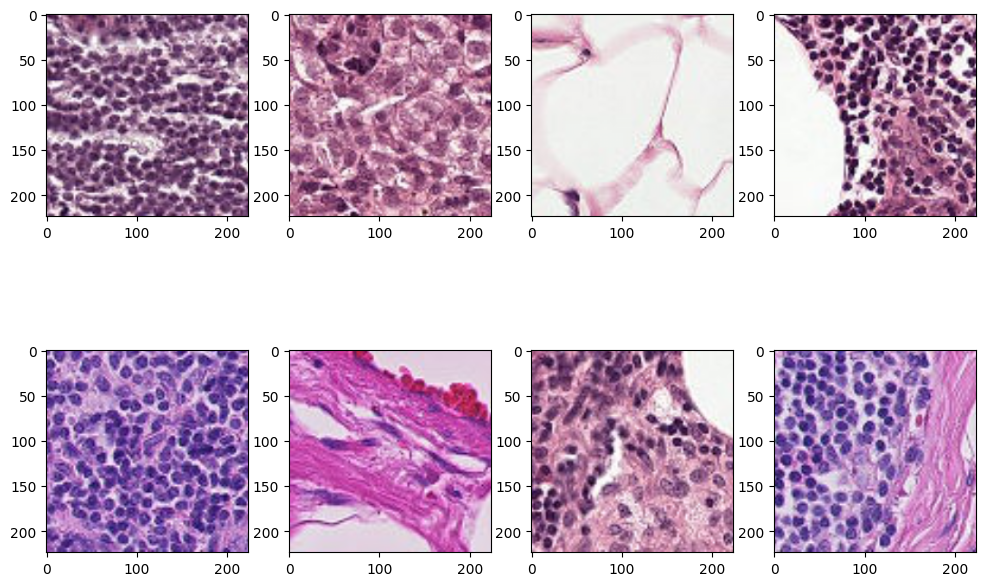

In [161]:
testDataPlot(confirmation)

### Loading the Model

Here we load the model, and send it to the GPU. Below you can see some specifications of the model

In [162]:
testNet = Net()
testNet.load_state_dict(torch.load('./classifier.pth'))
testNet.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=44944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [19]:
testDF = pd.read_csv('histopathologic-cancer-detection/sample_submission.csv')

### Comparison

Finally - we can compare the trained model using our test data. We follow a similar procedure as before - we take the tensors of the data, run it through the model, calculate the loss / gradient, and then step through in our backwards propagation. We then compare predicted labels to the true labels as given to us in the sample_submission.csv file as we progress - at the end of the day, we have achieved an accuracy rate of 68.6% - not bad! Not great, but definitely significantly better than just picking at random. This goes to show that our model has successfully learned at least something. Let's move on to using a ResNet model, and lets see if that performs any better

In [216]:
correct = 0
total = 0
correctSampleList = []
incorrectSampleList = []

with torch.no_grad():
    for data in confirmationLoader:
        images, testData = data
        imageList = [os.path.splitext(filename)[0] for filename in images['ID']]
        # calculate outputs by running images through the network
        outputs = net(testData.to(device))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        predictedArray = [tensor.cpu().numpy() for tensor in predicted]
        predictedList = [values.item() for values in predictedArray]
        prediction = list(zip(imageList, predictedList))
        total += testData.size(0)
        for sample in prediction:
            trueLabel = testDF[testDF['id'] == sample[0]]['label']
            trueLabel = trueLabel.values[0]
            if(trueLabel == sample[1]):
                correct += 1
                correctSampleList.append(sample[0])
            else:
                correct += 0
                incorrectSampleList.append(sample[0])


In [217]:
correctPrediction = "The percentage of correctly predicted labels is: {}".format(correct/total)
print(correctPrediction)

The percentage of correctly predicted labels is: 0.686449232482857


### Resnet Training

So now that we have trained our basic model, lets take a look at building the model using ResNet. ResNet is a model type where the deeper network propagation problem has been "fixed", and the layers learn residual functions with reference to their inputs. There are many different ResNet models, named after the number of layers that are activated in the model. One thing with ResNet is that they expect their inputs to be very particular, so we will need to add on some extra normalization to our datasets to accomplish this. Let's do this now. In addition, we need to resize the images so that they are at 224x224 pixels, as the resnet model requires that as a minimum image width

In [9]:
resnetTransform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), transforms.Resize((224, 224))])
resnetTest = CancerDiagnosisDataset(trainingLabels, trainPath, resnetTransform)
resnetLoader = torch.utils.data.DataLoader(resnetTest, shuffle=True, batch_size=48, num_workers=0)

We can now import the model to use on our data

In [34]:
model = torchvision.models.resnet50()
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Training Resnet-18

Here we actually train the resnet-18 model. We follow many of the same steps as before

In [11]:
learning_rate = 0.00001
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
num_epochs = 2
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(resnetLoader, 0):
        info, inputs = data
        optimizer.zero_grad()
        outputs = model(inputs.to(device))
        labels = info['Label']
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')



[1,  2000] loss: 0.629
[1,  4000] loss: 0.459
[1,  6000] loss: 0.387
[1,  8000] loss: 0.344
[1, 10000] loss: 0.309
[1, 12000] loss: 0.292
[1, 14000] loss: 0.284
[1, 16000] loss: 0.253
[1, 18000] loss: 0.267
[1, 20000] loss: 0.242
[1, 22000] loss: 0.236
[1, 24000] loss: 0.237
[1, 26000] loss: 0.241
[1, 28000] loss: 0.216
[1, 30000] loss: 0.230
[1, 32000] loss: 0.239
[1, 34000] loss: 0.215
[1, 36000] loss: 0.215
[1, 38000] loss: 0.216
[1, 40000] loss: 0.207
[1, 42000] loss: 0.205
[1, 44000] loss: 0.197
[1, 46000] loss: 0.192
[1, 48000] loss: 0.193
[1, 50000] loss: 0.193
[1, 52000] loss: 0.199
[1, 54000] loss: 0.180
Epoch 1/2, Loss: 2.1356
[2,  2000] loss: 0.176
[2,  4000] loss: 0.165
[2,  6000] loss: 0.171
[2,  8000] loss: 0.184
[2, 10000] loss: 0.162
[2, 12000] loss: 0.181
[2, 14000] loss: 0.170
[2, 16000] loss: 0.157
[2, 18000] loss: 0.167
[2, 20000] loss: 0.165
[2, 22000] loss: 0.163
[2, 24000] loss: 0.168
[2, 26000] loss: 0.171
[2, 28000] loss: 0.159
[2, 30000] loss: 0.151
[2, 32000]

In [12]:
respath = './res-classifier.pth'
torch.save(net.state_dict(), respath)

### Comparison and Analysis of Resnet-18

Now that we have trained and saved the model, we can compare it with our sample submissions and see what kind of accuracy we can achieve. We follow the same steps as before for looking at test sample space, only with our resnet trained model now. We then see after the model that we have achieved a lower prediction rate. Interesting, and not what I had expected, considering that the loss experienced in the training was so low. I think may have to do with our batch size, and the fact that I used a pretrained model loaded with weights for training, so let's ameliorate those hyperparameters

In [28]:
resnetTestTransform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), transforms.Resize((224, 224))])
resnetTestConfirm = TestingCancerDiagnosisDataset(rootDir=testPath, transform=resnetTestTransform)
resnetTestLoader = torch.utils.data.DataLoader(resnetTestConfirm, shuffle=True, batch_size=4, num_workers=0)

In [29]:
total = 0
correct = 0
resCorrectSampleList = []
resIncorrectSampleList = []
with torch.no_grad():
    for data in resnetTestLoader:
        images, testData = data
        imageList = [os.path.splitext(filename)[0] for filename in images['ID']]
        # calculate outputs by running images through the network
        outputs = model(testData.to(device))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        predictedArray = [tensor.cpu().numpy() for tensor in predicted]
        predictedList = [values.item() for values in predictedArray]
        prediction = list(zip(imageList, predictedList))
        total += testData.size(0)
        for sample in prediction:
            trueLabel = testDF[testDF['id'] == sample[0]]['label']
            trueLabel = trueLabel.values[0]
            if(trueLabel == sample[1]):
                correct += 1
                resCorrectSampleList.append(sample[0])
            else:
                correct += 0
                resIncorrectSampleList.append(sample[0])

In [30]:
correctPrediction = "The percentage of correctly predicted labels using the ResNet-18 model is: {}".format(correct/total)
print(correctPrediction)

The percentage of correctly predicted labels using the ResNet-18 model is: 0.6103240627936928


### Amelioration of HyperParameters

I keep the transformations the same, as they are required for resnet, but I declare a new model without the weights, and increase the batch size of the data that is fed to the model. Ideally, this will lead to a more stable and faster convergence. I expect the loss to be greater now, but hopefully that does not affect accuracy

In [38]:
resnetTransform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), transforms.Resize((224, 224))])
resnetTest = CancerDiagnosisDataset(trainingLabels, trainPath, resnetTransform)
resnetLoader = torch.utils.data.DataLoader(resnetTest, shuffle=True, batch_size=64, num_workers=0)

model = torchvision.models.resnet18()
model.to(device)



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Training
Just as predicted, the loss increased. We will now move back to actually testing the model

In [39]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
num_epochs = 2
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(resnetLoader, 0):
        info, inputs = data
        optimizer.zero_grad()
        outputs = model(inputs.to(device))
        labels = info['Label']
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')


[1,  2000] loss: 0.389
Epoch 1/2, Loss: 0.3129
[2,  2000] loss: 0.259
Epoch 2/2, Loss: 0.1758


### Model Test

Incredibly disappointing. The accuracy somehow went down after making our adjustments - from 61% to 60.8%. From these results, our resnet model does not do better than the "basic" model that I built at the beginning.

In [40]:
resnetTestTransform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), transforms.Resize((224, 224))])
resnetTestConfirm = TestingCancerDiagnosisDataset(rootDir=testPath, transform=resnetTestTransform)
resnetTestLoader = torch.utils.data.DataLoader(resnetTestConfirm, shuffle=True, batch_size=64, num_workers=0)

In [41]:
total = 0
correct = 0
resCorrectSampleList = []
resIncorrectSampleList = []
with torch.no_grad():
    for data in resnetTestLoader:
        images, testData = data
        imageList = [os.path.splitext(filename)[0] for filename in images['ID']]
        # calculate outputs by running images through the network
        outputs = model(testData.to(device))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        predictedArray = [tensor.cpu().numpy() for tensor in predicted]
        predictedList = [values.item() for values in predictedArray]
        prediction = list(zip(imageList, predictedList))
        total += testData.size(0)
        for sample in prediction:
            trueLabel = testDF[testDF['id'] == sample[0]]['label']
            trueLabel = trueLabel.values[0]
            if(trueLabel == sample[1]):
                correct += 1
                resCorrectSampleList.append(sample[0])
            else:
                correct += 0
                resIncorrectSampleList.append(sample[0])

In [45]:
correctPrediction = "The percentage of correctly predicted labels using the ResNet-18 model is: {}".format(correct/total)
print(correctPrediction)


The percentage of correctly predicted labels using the ResNet-18 model is: 0.6083226008562777


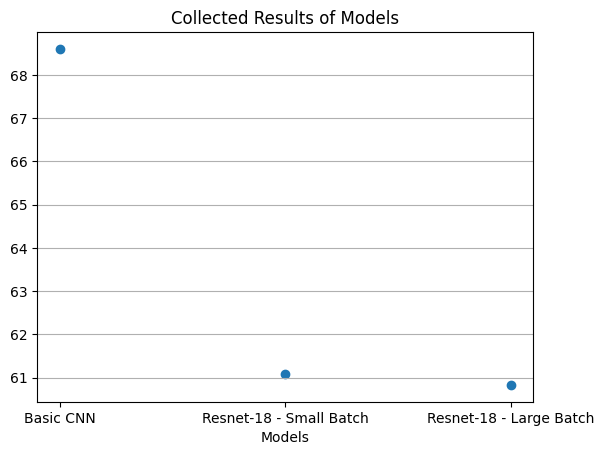

In [53]:
plt.figure()
x_data = ['Basic CNN', 'Resnet-18 - Small Batch', 'Resnet-18 - Large Batch']
y_data = [68.6, 61.082,60.832]
plt.title('Collected Results of Models')
plt.xlabel('Models')
plt.grid(axis='y')
plt.scatter(x_data, y_data)

### Conclusion

There are many different ways that I could take this. First, I could use a different resnet model: I am using resnet-18, but perhaps I could increase it to resnet-50 and see if that performs better, or even Resnet-100. The issue with that however is actually having access to an appropriate GPU in order to train these models - time was not 'prohibitive' here, but it stacked up quickly as I worked on this project. Second, I could attempt to use a hyperparameter optimization method, perhaps the issue was that I chose an incorrect learning rate or that I need a very small or very large batch size. Perhaps I could also have done more transformations, maybe I didn't hit the right amount of transformations for it to work. Either way - training these models is tough, and takes a lot of work to tune and get working appropriately. I am pleased that my 'basic' one did okay, I am less pleased how the resnet results turned out.